# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

from deap import algorithms, base, creator, tools

from sympy import *

from scipy.stats import spearmanr

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [2]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [3]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [4]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [5]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

In [135]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor' # Solve for this by setting the other (e.g. solve = cInhibitor if cActivator is known)

input_range = {
    'cActivator': [0,100],
    #'cInhibitor': [0,50],
}

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 101, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values[list(input_range.keys())[0]] = pair[0] #NOTE: May break if we try to run both at same time
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Remove negative elements from working_grid
    working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [148]:
# Create a combined grid
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

cAct_range = {'cActivator': [0,2]} # Use a log10 range
cInh_range = {'cInhibitor': [-1,4]} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = create_parameter_grid(num_steps = 101, **cAct_range)
    cAct_grid = [[10**x[0]] for x in cAct_grid]
    cInh_grid = create_parameter_grid(num_steps = 101, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function
        cAct_grid[ii] = (cAct_grid[ii][0], (lambda_df.loc['cInhibitor','lambda'](values_tuple))[0])

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0], cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids
    
    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Remove negative elements from working_grid
    working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]

    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [149]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.07390374033635091, 0.1), (0.07515356672096..."
control__wt_glc__2,2.369230,"[(0.0884301336265355, 0.1), (0.089846416823985..."
fur__wt_dpd__1,0.490542,"[(0.0011348626582396613, 1.2589254117941675), ..."
fur__wt_dpd__2,0.492320,"[(0.001277544681404343, 1.2589254117941675), (..."
fur__wt_fe__1,1.756930,"[(0.044264401834296155, 0.1), (0.0451745933403..."


# DEAP

In [8]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()

random.seed(42)

def generate_individual(individual_class: type, data: pd.DataFrame):
    individual = individual_class(random.sample(grid,1)[0] for grid in grid['grid'])
    
    return individual

toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 data = grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

In [9]:
# Evaluate
MA_df = data.iloc[:,0:2]

def spearman_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate spearman coefficient between cAct/cInh and MA_act/MA_inh
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """

    MA_activator = MA_df.loc[:,'MA_activator']
    MA_inhibitor = MA_df.loc[:,'MA_inhibitor']
    
    # NOTE: Need to swap 0 and 1 depending if calculating using cInhibitor or cActivator
    # NOTE: This is hardcoded and may break depending on if we try to run the two simultaneously
    if solve == 'cInhibitor':
        ind_activator = individual[:,0]
        ind_inhibitor = individual[:,1]
    else:
        ind_activator = individual[:,1]
        ind_inhibitor = individual[:,0]
    
    activator_spearman = spearmanr(MA_activator, ind_activator)[0]
    inhibitor_spearman = spearmanr(MA_inhibitor, ind_inhibitor)[0]
    
    return activator_spearman, inhibitor_spearman,

toolbox.register(alias = 'evaluate', function = spearman_objective, MA_df = MA_df)

In [114]:
toolbox.register("select", tools.selNSGA2, nd='log')
#toolbox.register("select", tools.selSPEA2)

In [11]:
# Mutation
def mutate(individual: object, prob: float, grid: pd.DataFrame):
    # Iterate over all conditions if an individual is selected to mutate
    for i, _ in enumerate(individual):
        if random.random() < prob:
            # Select a new set of parameters for a condition from the grid
            # Requires the "grid" to be in a specific location of the dataframe
            individual[i] = random.sample(grid.iloc[i,1],1)[0] 

    return individual,

mt_prob = 0.1  #NOTE: CHANGE ME
toolbox.register('mutate', function = mutate, prob = mt_prob, grid = grid)

In [12]:
# Crossover
def crossover(ind_one: object, ind_two: object, prob: float,):

    for i, _ in enumerate(ind_one):
        if random.random() < prob:
            # Use copies of individuals to avoid modifying the np.array in place
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

cx_prob = 0.1 # NOTE: CHANGE ME

toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

In [13]:
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],ind.fitness.values[1]))
stats.register("max", np.max)

In [14]:
def best_individual(population: list):
    """
    Returns a list containing the total scores for each individual and a list 
    containining the np.argsort indices for the ascending sorted scores

    :param list population: List of individuals with fitness scores
    """
    a, b = zip(*[population[i].fitness.values for i in range(len(population))])
    total_scores = np.subtract(a,b) # Since objective weights are (1.0, -1.0)
    sorted_index = np.argsort(total_scores)

    return total_scores, sorted_index

In [151]:
def mu_plus_lambda(population = list,
                   toolbox = base.Toolbox(),
                   mu = int,
                   lambda_ = int,
                   cxpb = float,
                   mutpb = float,
                   n_gen = int,
                   n_iter = int,
                   grid = pd.Series,
                   stats = None,
                   hall_of_fame = None,
                   verbose = __debug__):
    """
    Modified DEAP mu+lambda evolutionary algorithm using varOr

    :param list population: List of individuals to serve as the starting population
    :param base.Toolbox() toolbox: DEAP class containing evolution operators
    :param int mu: Number of individuals to select for the next generation
    :param int lambda_: Number of children to produce at each generation
    :param float cxpb: Probability that an offspring is produced by crossover
    :param float mutpb: Probability that an offspring is produced by mutation
    :param int n_gen: Number of generations to run
    :param int n_iter: Greedy offspring population size
    :param pd.Series grid: Series containing grids for each condition
    :param stats: DEAP class containing the types of statistics to record in the logbook
    :param halloffame: DEAP class containing the best individuals evaluated
    :param verbose: Whether or not to print statistics for each generation
    :returns list pop: Final population
    :returns logbook: DEAP class containing stats for every generation

    evaluate(population)
    for g in range(ngen):
        offspring = varOr(population, toolbox, lamda_, cxpb, mutpb)
        evaluate(offspring)
        gradient_offspring = create_gradient_offspring(hof[0], toolbox)
        evaluate(gradient_offspring)
        population = select(population+offspring+gradient_offspring, mu)
    """

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals', 'best'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if hall_of_fame is not None:
        hall_of_fame.update(population)

    total_scores, sorted_index = best_individual(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, n_gen + 1):
        # Vary the population
        offspring = algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Greedy offspring
        if gen % 100 == 0:
            greedy_offspring, _ = create_greedy_offspring(population[sorted_index[-1]], n_iter, grid)
            offspring = offspring+greedy_offspring

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        # NOTE: I feel like HoF should update after the next population is created? That way we only have to compare max mu individuals to the HoF?
        if hall_of_fame is not None:
            hall_of_fame.update(offspring)

        # Manually ensure elitism
        population = population + offspring
        temp_score, temp_sorted = best_individual(population)
        hof_individual = population[temp_sorted[-1]]

        # Select the next generation population
        population[:] = toolbox.select(population, mu)
        population.append(hof_individual)

        # Update the statistics with the new population
        total_scores, sorted_index = best_individual(population)

        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [157]:
# NOTE: Using np.ndarray individuals requires a different method to compare individuals
nind = 100
mu = 100
lambda_ = 100
cxpb = 0.7
mutpb = 0.3
n_gen = 1000
n_iter = 0

pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_iter = n_iter, grid = grid.grid, stats=stats, verbose=True)
# pop, logbook = algorithms.eaMuPlusLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, ngen=n_gen, stats=stats, halloffame=hof, verbose=True)

gen	nevals	best    	max     
0  	100   	0.517871	0.517871
1  	100   	0.517871	0.517871
2  	100   	0.550333	0.550333
3  	100   	0.558651	0.558651
4  	100   	0.593579	0.593579
5  	100   	0.613143	0.613143
6  	100   	0.627383	0.627383
7  	100   	0.645129	0.645129
8  	100   	0.662358	0.662358
9  	100   	0.677803	0.677803
10 	100   	0.702468	0.702468
11 	100   	0.738532	0.738532
12 	100   	0.743576	0.743576
13 	100   	0.743576	0.743576
14 	100   	0.775855	0.775855
15 	100   	0.78706 	0.78706 
16 	100   	0.78706 	0.78706 
17 	100   	0.802809	0.802809
18 	100   	0.818662	0.818662
19 	100   	0.818662	0.818662
20 	100   	0.84361 	0.84361 
21 	100   	0.881189	0.881189
22 	100   	0.881189	0.881189
23 	100   	0.881189	0.881189
24 	100   	0.885708	0.885708
25 	100   	0.891856	0.891856
26 	100   	0.891856	0.891856
27 	100   	0.921768	0.921768
28 	100   	0.922298	0.922298
29 	100   	0.937603	0.937603
30 	100   	0.948612	0.948612
31 	100   	0.959034	0.959034
32 	100   	0.988109	0.988109
33 	100   	0.9

## Visualizing GA results

In [158]:
total_score, total_sort = best_individual(pop)

In [159]:
total_score[total_sort[-1]]

1.3466082004534219

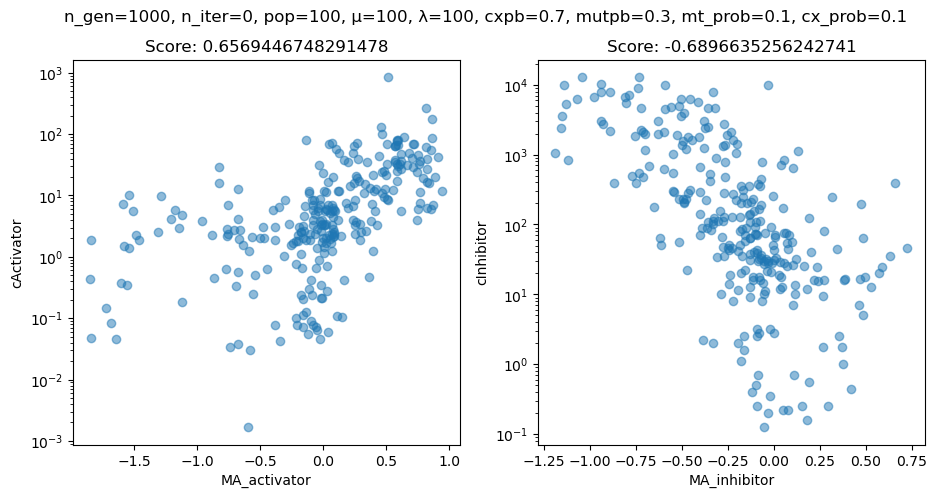

In [160]:
plot_individual = pop[total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

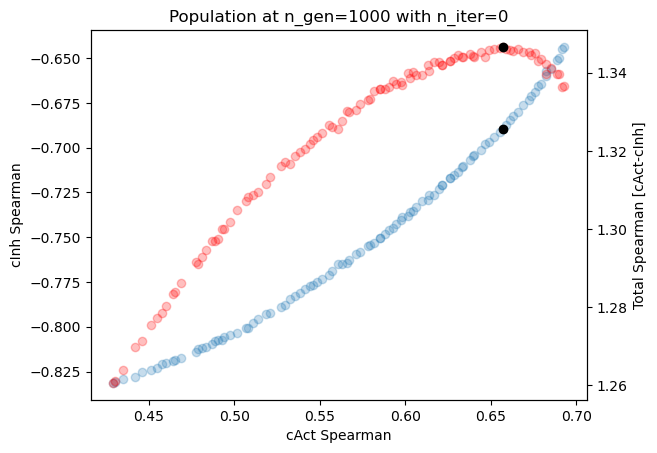

In [161]:
# Plot the final population and their total score
a, b = zip(*[pop[i].fitness.values for i in range(len(pop))])

fig, ax1 = plt.subplots()
ax1.scatter(a, b, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(a, total_score, alpha=0.25, c='r')
ax1.set_title('Population at n_gen='+str(n_gen)+' with n_iter='+str(n_iter))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')
ax1.scatter(a[total_sort[-1]], b[total_sort[-1]], c='k')
ax2.scatter(a[total_sort[-1]], total_score[total_sort[-1]], c='k')

In [344]:
# Plot fitness of best individuals over time and compare to hof
gen = np.linspace(0, n_gen, n_gen+1)
gen_min = []
gen_max = []

for gen_dict in logbook:
    gen_min.append(gen_dict['min'])
    gen_max.append(gen_dict['max'])

fig, [ax1, ax2] = plt.subplots(1,2)
title = 'n_gen='+str(n_gen)+', n_steps='+str(n_steps)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+',\ncxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.plot(gen, gen_min)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Spearman Score')

ax2.plot(gen, gen_max)
ax2.set_xlabel('Generation')

KeyError: 'min'

Text(0, 0.5, 'Total Spearman [cAct-cInh]')

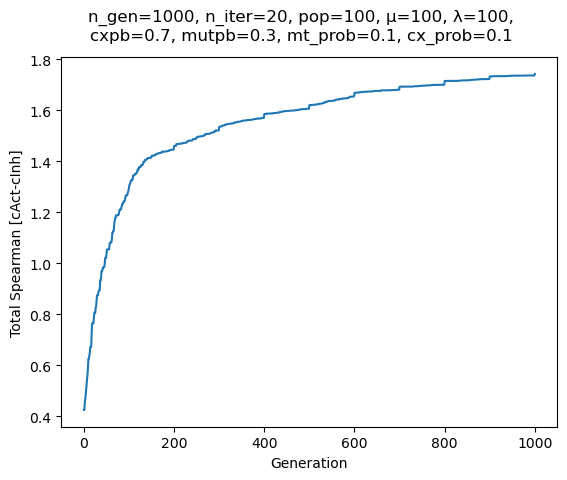

In [147]:
# Plot fitness of best individuals over time and compare to hof
gen = np.linspace(0, n_gen, n_gen+1)
gen_score = []

for gen_dict in logbook:
    gen_score.append(gen_dict['max'])

fig, ax = plt.subplots()
title = 'n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+',\ncxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax.plot(gen[:], gen_score[:])
ax.set_xlabel('Generation')
ax.set_ylabel('Total Spearman [cAct-cInh]')

## Going through the NSGA-II algorithm

In [92]:
pareto_fronts = tools.sortLogNondominated(pop, 100)
for front in pareto_fronts:
    tools.emo.assignCrowdingDist(front)

pop[total_sort[-1]].fitness.crowding_dist

0.012441447960291951

## "Greedy Offspring"

In [117]:
# SECOND DRAFT
# Rather than deal with having to look up where the tuple is, I think my next step should be to make the first n tuples correspond to the locations of the n parameters that are set in each tuple
# For this case, that would mean that the first number would correspond to the position of the cAct value in the list
def create_greedy_offspring(base_individual: object,
                            n_iterations: int,
                            grid: pd.Series):
    """
    Returns a population of modified individuals that have different parameters
    for one condition

    :param object base_individual: Individual to copy parameters from
    :param int n_iterations: How many random copies should be created
    :param pd.Series grid: Series containing grids for each condition
    """
    
    # Create population to hold the individuals we are trying out
    population = toolbox.population(n=0)

    # Create a pd.Series to hold position of each condition's parameter tuple
    position = pd.Series(index = grid.index, dtype = 'Int64')

    for i, (ind_act, ind_inh) in enumerate(base_individual):
        # Iterate through the grid parameters for each condition
        for ii, (grid_act, grid_inh) in enumerate(grid[i]):
            if (ind_act, ind_inh) == (grid_act, grid_inh):
                position[i] = ii

    # Record the number of steps needed for each condition at each iteration
    steps = pd.DataFrame(index=grid.index, columns=range(n_iterations))

    # Shuffle the order of the conditions and run it many times
    for i in range(n_iterations):
        # Copy the grid and position series and shuffle them
        temp_grid = grid.sample(frac=1, replace=False, random_state=i)
        temp_position = position.reindex(temp_grid.index)

        # Create the iteration's temporary individual
        base_score = np.subtract(base_individual.fitness.values[0], base_individual.fitness.values[1])
        temp_individual = creator.individual(base_individual)

        # Baseline
        old_l_score = base_score
        old_r_score = base_score

        # Loop over the shuffled conditions
        for cond in temp_grid.index:
            # Create the condition's temporary individuals
            l_individual = creator.individual(temp_individual)
            r_individual = creator.individual(temp_individual)

            # Identify where in the individual the condition's parameters are
            cond_loc = grid.index.get_loc(cond)

            # Determine where in the grid the condition's parameters are
            l_position = int(temp_position[cond]-1)
            r_position = int(temp_position[cond]+1)

            # Search the "left" side
            while l_position > -1:
                # Modify the individual, evaluate, and score
                l_individual[cond_loc] = temp_grid[cond][l_position]
                l_individual.fitness.values = toolbox.evaluate(l_individual)
                new_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])

                # Compare the score against the best individual
                if new_l_score > old_l_score: # Check the next "left" position
                    l_position -= 1
                else: # Roll the individual back one step
                    l_position += 1
                    l_individual[cond_loc] = temp_grid[cond][l_position]
                    l_individual.fitness.values = toolbox.evaluate(l_individual)
                    old_l_score = np.subtract(l_individual.fitness.values[0],l_individual.fitness.values[1])
                    break

            # Search the "right" side
            while r_position < len(temp_grid[cond]):
                # Modify the individual, evaluate, and score
                r_individual[cond_loc] = temp_grid[cond][r_position]
                r_individual.fitness.values = toolbox.evaluate(r_individual)
                new_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])

                # Compare the score against the best individual
                if new_r_score > old_r_score: # Check the next "left" position
                    r_position += 1
                else: # Roll the individual back one step
                    r_position -= 1
                    r_individual[cond_loc] = temp_grid[cond][r_position]
                    r_individual.fitness.values = toolbox.evaluate(r_individual)
                    old_r_score = np.subtract(r_individual.fitness.values[0],r_individual.fitness.values[1])
                    break

            # Compare r_individual and l_individual, use best
            if old_r_score > old_l_score:
                temp_individual = r_individual
                new_position = r_position
            else:
                temp_individual = l_individual
                new_position = l_position
            temp_individual.fitness.values = toolbox.evaluate(temp_individual)

            # Determine steps from original positions
            steps.loc[cond, i] = abs(temp_position[cond]-new_position)
            
        # Add individual to population
        population.append(temp_individual)
    
    return population, steps

In [162]:
np.subtract(pop[total_sort[-1]].fitness.values[0],pop[total_sort[-1]].fitness.values[1])

1.3466082004534219

In [163]:
n_iter = 10
test_greedy_pop, steps = create_greedy_offspring(pop[total_sort[-1]], n_iter, grid.grid)
greedy_score, greedy_sort = best_individual(test_greedy_pop)

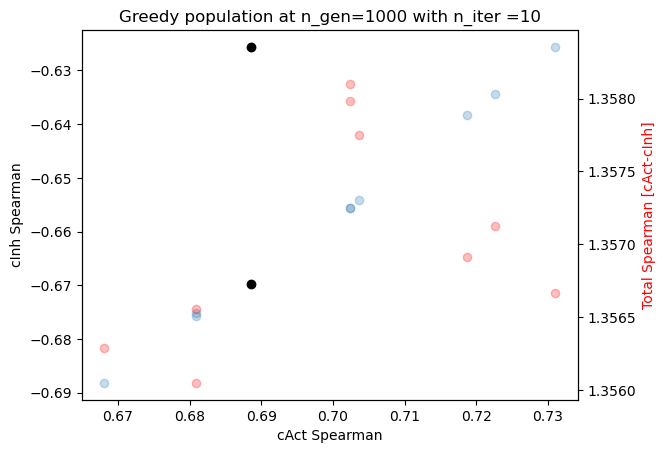

In [164]:
# Plot the final population and their total score
a, b = zip(*[test_greedy_pop[i].fitness.values for i in range(len(test_greedy_pop))])

fig, ax1 = plt.subplots()
ax1.scatter(a, b, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(a, greedy_score, alpha=0.25, c='r')
ax1.set_title('Greedy population at n_gen='+str(n_gen)+' with n_iter ='+str(n_iter))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]', c='r')
ax1.scatter(a[greedy_sort[-1]], b[greedy_sort[-1]], c='k')
ax2.scatter(a[greedy_sort[-1]], greedy_score[greedy_sort[-1]], c='k')

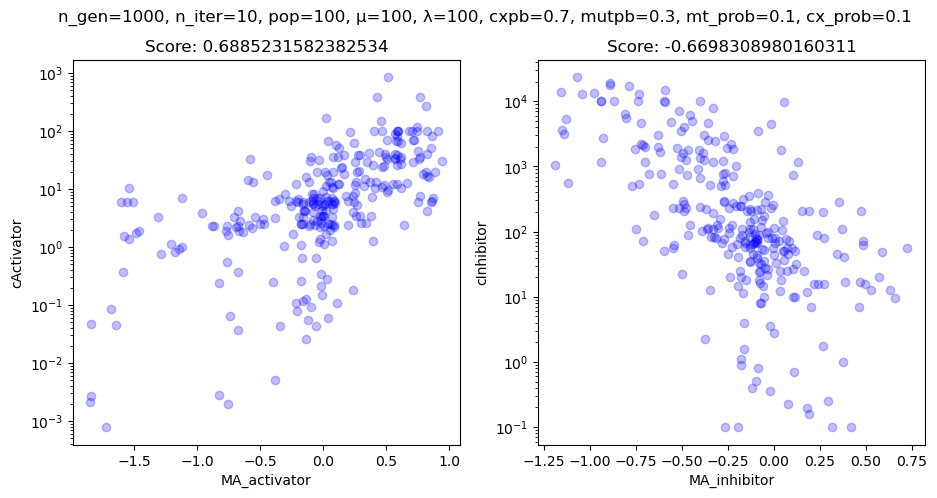

In [165]:
plot_individual = test_greedy_pop[greedy_sort[-1]]
red_individual = pop[total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_title('Score: '+str(plot_individual.fitness.values[0]))
ax2.set_title('Score: '+str(plot_individual.fitness.values[1]))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.25, c='b')
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.25, c='b')
    #ax1.scatter(MA_df.iloc[:,0], red_individual[:,0], alpha=0.25, c='r')
    #ax2.scatter(MA_df.iloc[:,1], red_individual[:,1], alpha=0.25, c='r')
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5, c='b')
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5, c='b')

In [33]:
grid.grid[0]

[(0.16609010284913425, 1.0),
 (0.1868079056192276, 1.202264434617413),
 (0.21171618305312886, 1.4454397707459274),
 (0.24166251913949194, 1.7378008287493754),
 (0.2776659339632262, 2.0892961308540396),
 (0.32095155913057927, 2.51188643150958),
 (0.3729923267994683, 3.019951720402016),
 (0.43555909091796124, 3.630780547701014),
 (0.5107808862067224, 4.36515832240166),
 (0.6012173753904712, 5.248074602497725),
 (0.7099459499277551, 6.309573444801933),
 (0.8406664481205797, 7.5857757502918375),
 (0.9978270539732826, 9.120108393559097),
 (1.0, 9.141322501272432),
 (1.096478196143185, 10.083222953379174),
 (1.1867756609129128, 10.964781961431852),
 (1.202264434617413, 11.115996262051626),
 (1.318256738556407, 12.24840967656962),
 (1.413941851006935, 13.182567385564074),
 (1.4454397707459274, 13.490076294608663),
 (1.5848931924611136, 14.851536668167316),
 (1.6870556821045157, 15.848931924611133),
 (1.7378008287493754, 16.34434828268734),
 (1.9054607179632472, 17.981183668957843),
 (2.015410

## Number of Steps Greedy Offspring Take

In [166]:
steps

,0,1,2,3,4,5,6,7,8,9
control__wt_glc__1,52,28,0,0,40,18,21,23,0,0
control__wt_glc__2,77,0,2,2,2,1,1,0,2,20
fur__wt_dpd__1,46,44,46,0,0,46,45,45,50,0
fur__wt_dpd__2,0,54,0,51,48,0,0,0,0,0
fur__wt_fe__1,30,42,40,30,53,0,0,0,37,0
...,...,...,...,...,...,...,...,...,...,...
efeU__menFentCubiC_ale36__2,2,3,0,4,3,27,0,0,2,0
efeU__menFentCubiC_ale37__1,9,2,2,5,0,0,3,2,1,0
efeU__menFentCubiC_ale37__2,43,3,0,3,67,2,0,0,71,1
efeU__menFentCubiC_ale38__1,97,84,95,95,72,100,92,2,89,83


Text(0.5, 1.0, 'Median Number of Steps 10 Greedy Offspring Take \n Bin Width=2')

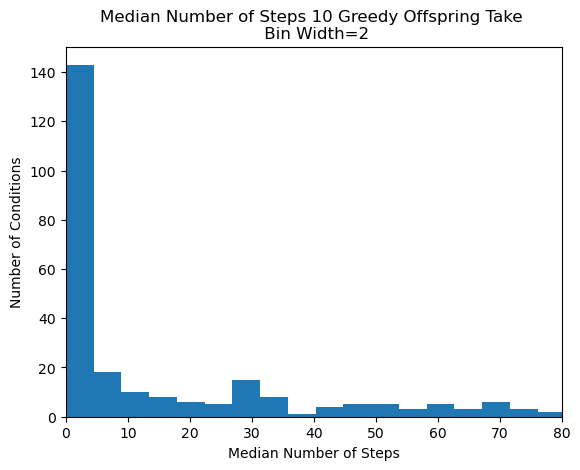

In [167]:
fig, ax = plt.subplots()
ax.hist(steps.median(axis=1), bins = 40)
ax.set_xlim(left=0, right=80)
ax.set_xlabel('Median Number of Steps')
ax.set_ylabel('Number of Conditions')
ax.set_title('Median Number of Steps '+str(n_iter)+' Greedy Offspring Take \n Bin Width=2')

### Labeling the Conditions that have a High Median Number of Steps

array([[<AxesSubplot:title={'center':'31'}>]], dtype=object)

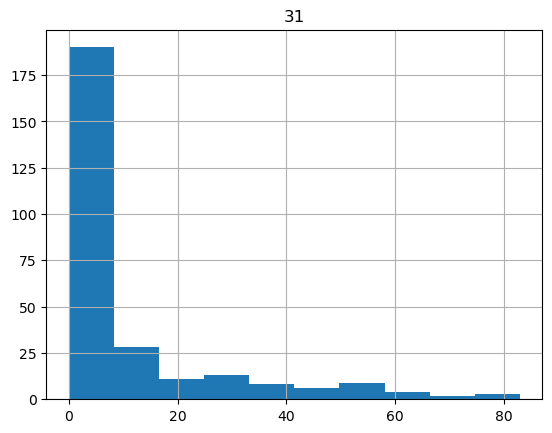

In [63]:
# Identify best individual and their corresponding steps
greedy_steps = pd.DataFrame(data = steps.iloc[:,greedy_sort[-1]], dtype='Int64')
greedy_steps.hist()

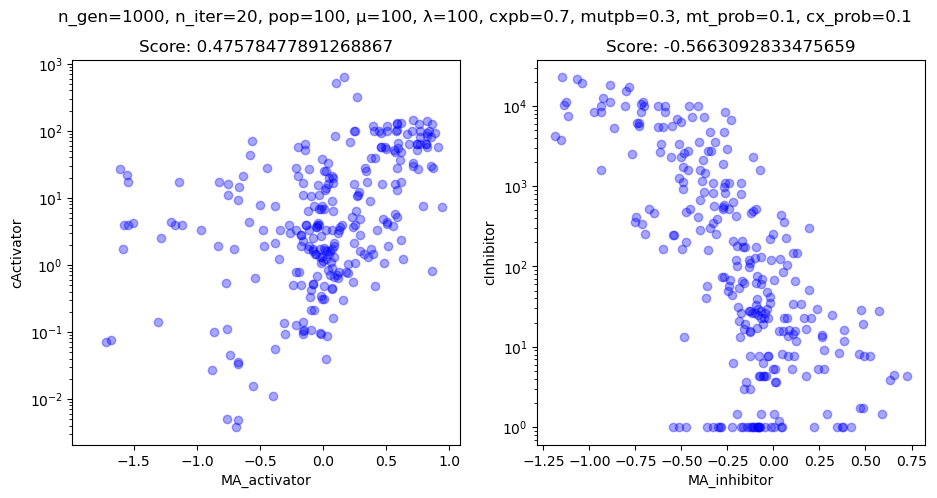

In [156]:
greedy_individual = test_greedy_pop[greedy_sort[-1]]
original_individual = pop[total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'n_gen='+str(n_gen)+', n_iter='+str(n_iter)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_title('Score: '+str(greedy_individual.fitness.values[0]))
ax2.set_title('Score: '+str(greedy_individual.fitness.values[1]))

ax1.scatter(MA_df.iloc[:,0], greedy_individual[:,0], alpha=0.35, c='b')
ax2.scatter(MA_df.iloc[:,1], greedy_individual[:,1], alpha=0.35, c='b')
#ax1.scatter(MA_df.iloc[:,0], original_individual[:,0], alpha=0.15, c='r')
#ax2.scatter(MA_df.iloc[:,1], original_individual[:,1], alpha=0.15, c='r')

# Label conditions with a high number of steps
label_index = greedy_steps.index[greedy_steps[greedy_sort[-1]] > 70] # Modify cutoff based on histogram
for cond in label_index:
    i = greedy_steps.index.get_loc(cond)
    #ax1.text(x=MA_df.iloc[i,0], y=greedy_individual[i,0], s=cond, c='g')
    #ax2.text(x=MA_df.iloc[i,1], y=greedy_individual[i,1], s=cond, c='g')
    #ax1.text(x=MA_df.iloc[i,0], y=original_individual[i,0], s=cond, c='k')
    #ax2.text(x=MA_df.iloc[i,1], y=original_individual[i,1], s=cond, c='k')
    #ax1.arrow(x=MA_df.iloc[i,0], y=original_individual[i,0], dx=0, dy=(greedy_individual[i,0]-original_individual[i,0]), length_includes_head=True, color='k')
    #ax2.arrow(x=MA_df.iloc[i,1], y=original_individual[i,1], dx=0, dy=(greedy_individual[i,1]-original_individual[i,1]), length_includes_head=True, color='k')

# Other Stuff

In [56]:
# Effect on scores
base_individual = pop[total_sort[-1]]
n_steps = 10
temp_population = create_greedy_offspring(base_individual, n_steps, grid.grid)+pop

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in temp_population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

c, d = zip(*[temp_population[i].fitness.values for i in range(len(temp_population))])
test_total_score = np.subtract(c,d)
test_total_sort = np.argsort(test_total_score)
test_best_location = test_total_sort[-1]
test_best_individual = temp_population[test_best_location]

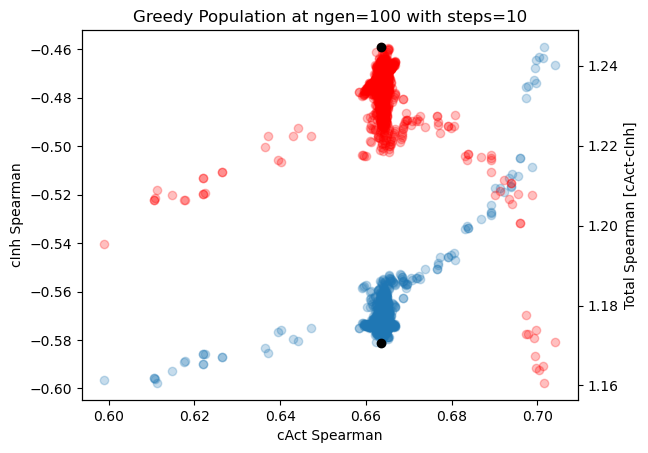

In [57]:
# Plot the final population and their total score
fig, ax1 = plt.subplots()
ax1.scatter(c, d, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(c, test_total_score, alpha=0.25, c='r')
ax1.set_title('Greedy Population at ngen='+str(n_gen)+' with steps='+str(n_steps))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')
ax1.scatter(c[test_best_location], d[test_best_location], c='k')
ax2.scatter(c[test_best_location], test_total_score[test_best_location], c='k')

In [86]:
test_total_score[test_total_sort]

array([1.40128868, 1.40517133, 1.40947944, ..., 1.56065093, 1.56145226,
       1.56202629])

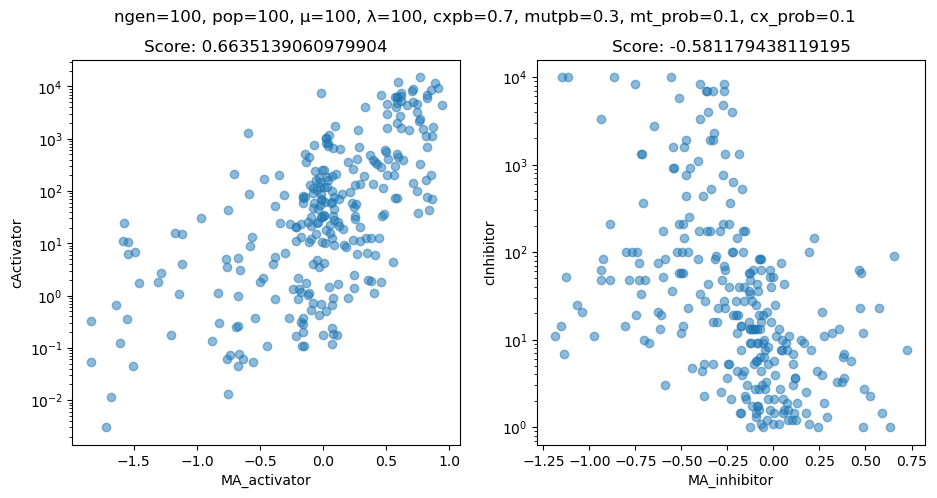

In [59]:
plot_individual = temp_population[test_total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(n_gen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

In [22]:
n_steps = 3
step_list = [step for step in range(-n_steps, n_steps+1) if step != 0]
print(step_list)

test_list = [0, 1, 2, 3, 4]
test_position = 3
print(test_list[test_position])

for step in step_list:
    if -1 < test_position+step < len(test_list):
        print(test_list[test_position+step])

[-3, -2, -1, 1, 2, 3]
3
0
1
2
4
